## For Colabs

In [1]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')

os.environ['GITHUB_AUTH'] = user + ':' + password
os.chdir("/content")
!rm -rf "/content/acse-9-independent-research-project-OliverJBoom"
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git
os.chdir("acse-9-independent-research-project-OliverJBoom/Src")

github password··········
Cloning into 'acse-9-independent-research-project-OliverJBoom'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 528 (delta 51), reused 46 (delta 21), pack-reused 446
Receiving objects: 100% (528/528), 7.72 MiB | 19.67 MiB/s, done.
Resolving deltas: 100% (289/289), done.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path = "/content/gdrive/My Drive/Chai/Data"

Mounted at /content/gdrive/


## Loading Packages

In [3]:
from deeplearning import *
from models import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
from preprocessing import *
from statistics import median
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from utils import *
import warnings

warnings.filterwarnings("ignore")

set_seed(42)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


True

### Insuring that training is done on GPU if available

In [4]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Loading Data

In [0]:
path = "Data/Commodity_Data/"
universe_dict = universe_select(path, "Cu")
use_lg_returns = False

## Preprocessing

In [6]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# Generating the dataset
if use_lg_returns:
  # Lg Returns Only
  df_full = generate_dataset(universe_dict, lg_returns_only=True, price_only=False)
  target_col = "cu_lme"
  
else:
  # Price Only
  df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=True)
  target_col = "price_cu_lme"

# Set to False initially
PCA_used = False

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


In [0]:
# Visualise the plots
# visualise_universe(universe_dict)

In [8]:
df_full.head(15)
# df_full.tail(5)

,price_cu_shfe,price_cu_lme,price_cu_comex_p,price_cu_comex_s,price_peso,price_sol,price_bdi,price_ted,price_vix,price_skew,price_gsci
date,,,,,,,,,,,
2006-09-13,69540.0,7484.5,3.3925,15748.0,537.35,3.2530,4129.0,4.901,11.18,120.44,438.38855
2006-09-14,71350.0,7439.0,3.3820,14180.0,537.73,3.2475,4207.0,4.926,11.55,119.47,433.72522
2006-09-15,69400.0,7281.0,3.3165,14775.0,537.10,3.2480,4258.0,4.939,11.76,135.25,431.58291
2006-09-18,69830.0,7459.0,3.4180,15263.0,537.10,3.2450,4279.0,4.949,11.78,127.35,434.97293
2006-09-19,71470.0,7516.0,3.3755,17523.0,537.10,3.2450,4275.0,4.948,11.98,125.03,426.51240
2006-09-20,69610.0,7474.0,3.3700,18091.0,537.80,3.2450,4244.0,4.937,11.39,122.71,418.32234
2006-09-21,70170.0,7602.0,3.4220,19546.0,539.70,3.2480,4200.0,4.921,12.25,119.68,423.56908
2006-09-22,71170.0,7601.0,3.4395,20627.0,538.50,3.2470,4136.0,4.924,12.59,118.86,418.01647
2006-09-25,71130.0,7560.0,3.4475,20978.0,539.30,3.2490,4069.0,4.907,12.12,120.75,418.93144


### Normalizing the dataset

In [0]:
# Forecast length
forecast_length = 5

# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[[target_col]]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = shift(data_y.ravel(), -forecast_length)[:-forecast_length]
# Check shape assert(data_X.shape[:, 0]== data_y.shape[0])

### PCA

In [10]:
# Reducing the dataset to containing a threshold amount of variance
n_dim = dimension_selector(data_X, thresh=0.95)
data_X = dimension_reduce(data_X, n_dim)

PCA_used = True

Number of dimensions: 6
Explained Variance: [0.49030338 0.23270694 0.1439148  0.04789975 0.02769706 0.0219951 ] 
Explained Variance Sum: 0.9645170286882985


### Slicing Series into Windows

In [0]:
# The input size of each time series window
series_length = 250
  
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=0.5)

### Hyperparameters

In [0]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32
test_batch_size = 1000
# series_length = 100

n_epochs = 5

# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 128
num_layers = 2
output_dim = 1
dropout = 0.2

### Initialising the model

In [0]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim, 
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 6 
hidden_dim 128
series_length 250 
batch_size 32
output_dim 1 
num_layers 2
data_X  (415, 250, 6) 
data_y (415,)


In [18]:
# Loading trained model
# model = torch.load("/content/gdrive/My Drive/Chai/Models/Pths/" + "partial_dataset_LSTM_0_1206.pth")
# model.to(device)

0.2


Epoch: 0 Train MSE: 0.06593 Val MSE: 0.47225  Time: 5.425


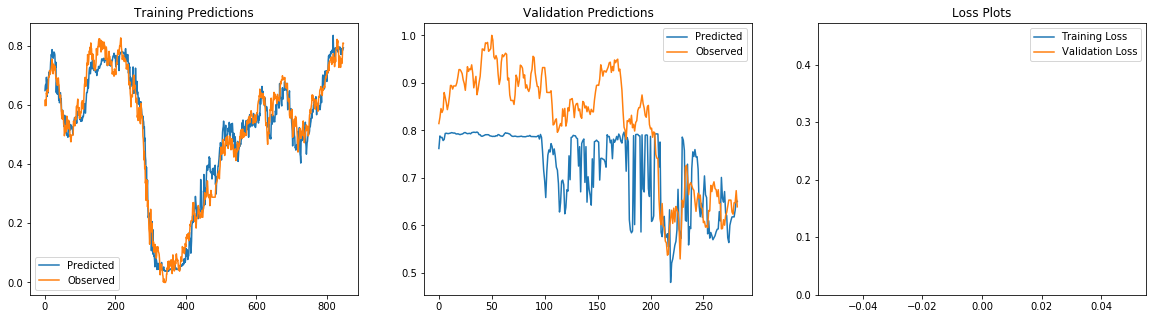

Epoch: 10 Train MSE: 0.39081 Val MSE: 0.17120  Time: 59.152
Epoch: 20 Train MSE: 0.08557 Val MSE: 0.50596  Time: 112.192


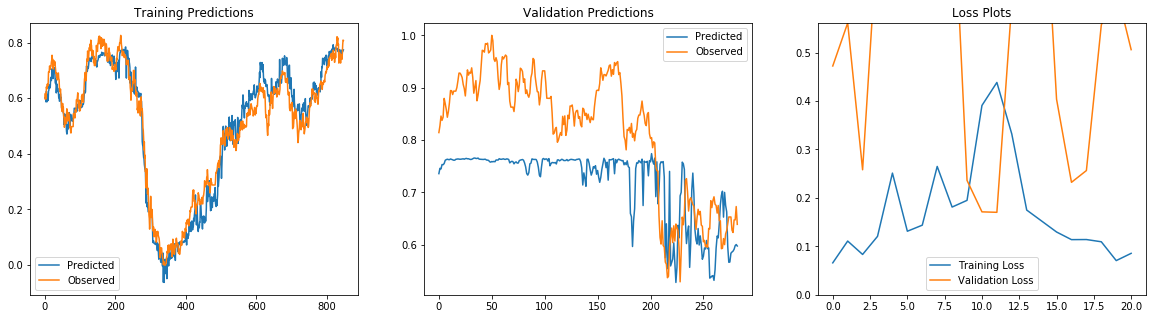

Epoch: 30 Train MSE: 0.07219 Val MSE: 0.34117  Time: 166.060
Epoch: 40 Train MSE: 2.13063 Val MSE: 5.44432  Time: 219.023


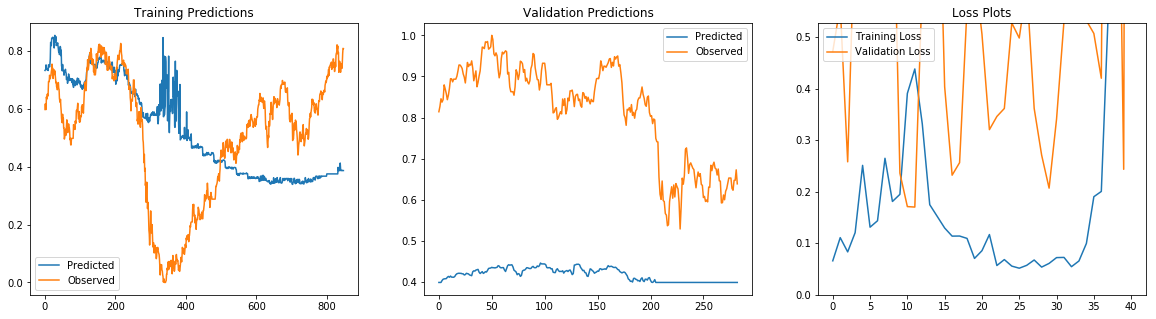

Epoch: 50 Train MSE: 0.29622 Val MSE: 1.48429  Time: 272.955
Epoch: 60 Train MSE: 0.07848 Val MSE: 0.24808  Time: 326.646


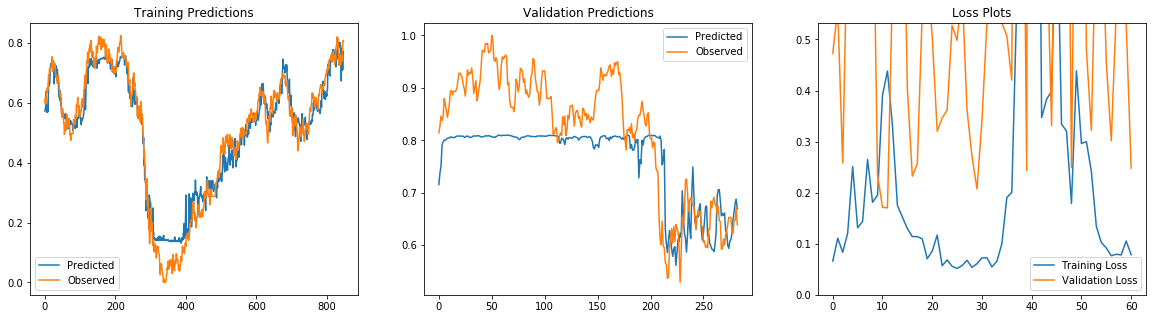

Epoch: 70 Train MSE: 0.08756 Val MSE: 0.22787  Time: 380.561
Epoch: 80 Train MSE: 0.11177 Val MSE: 0.49008  Time: 433.679


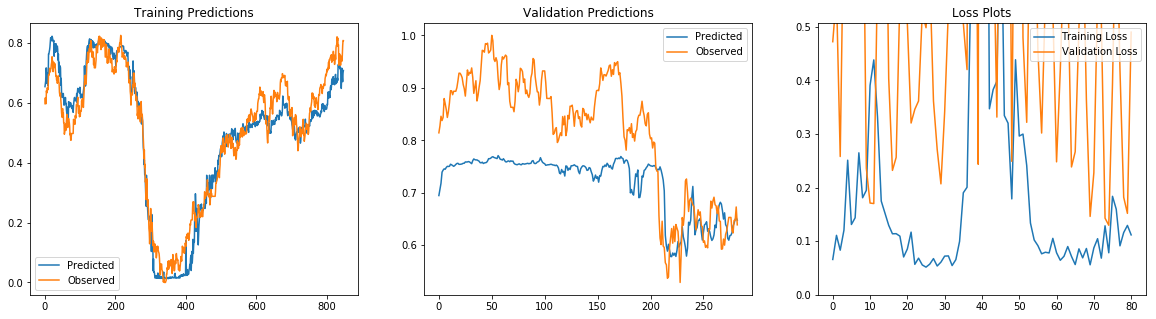

Epoch: 90 Train MSE: 0.05114 Val MSE: 0.38683  Time: 487.796
Epoch: 100 Train MSE: 0.11731 Val MSE: 0.28180  Time: 540.949


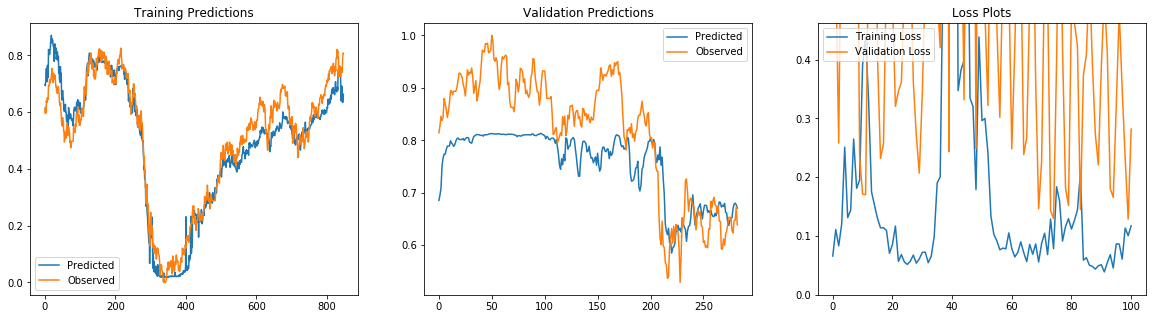

Epoch: 110 Train MSE: 0.04481 Val MSE: 0.36060  Time: 595.241
Epoch: 120 Train MSE: 0.07562 Val MSE: 0.56523  Time: 648.519


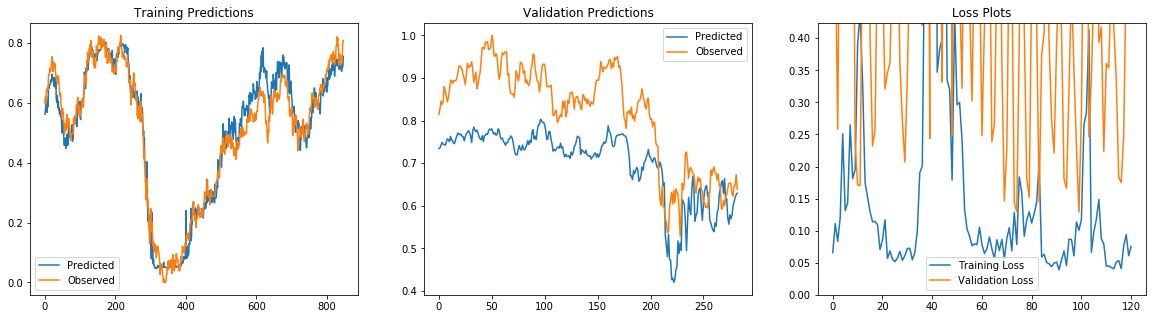

Epoch: 130 Train MSE: 0.19090 Val MSE: 0.29046  Time: 702.499
Epoch: 140 Train MSE: 0.14254 Val MSE: 0.15315  Time: 755.724


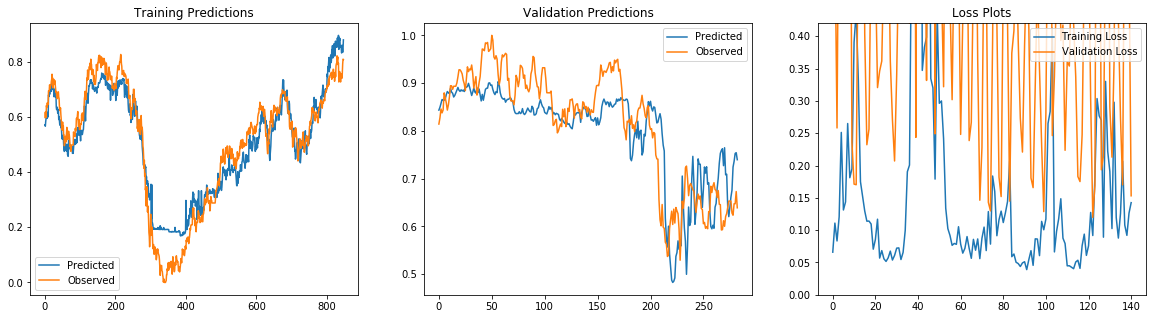

Epoch: 150 Train MSE: 0.10080 Val MSE: 0.26566  Time: 809.635
Epoch: 160 Train MSE: 0.04731 Val MSE: 0.62403  Time: 863.037


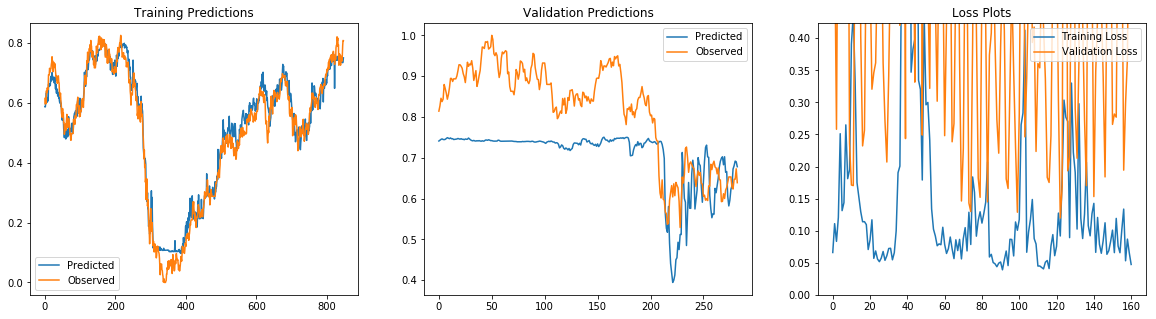

Epoch: 170 Train MSE: 0.12029 Val MSE: 0.77025  Time: 917.071
Epoch: 180 Train MSE: 0.21425 Val MSE: 0.47166  Time: 970.366


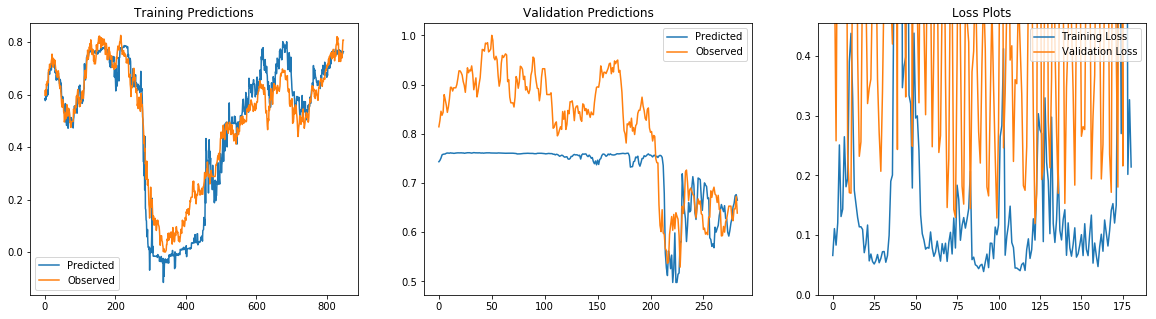

Epoch: 190 Train MSE: 0.08659 Val MSE: 0.35000  Time: 1024.458
Epoch: 200 Train MSE: 0.05180 Val MSE: 0.42684  Time: 1077.804


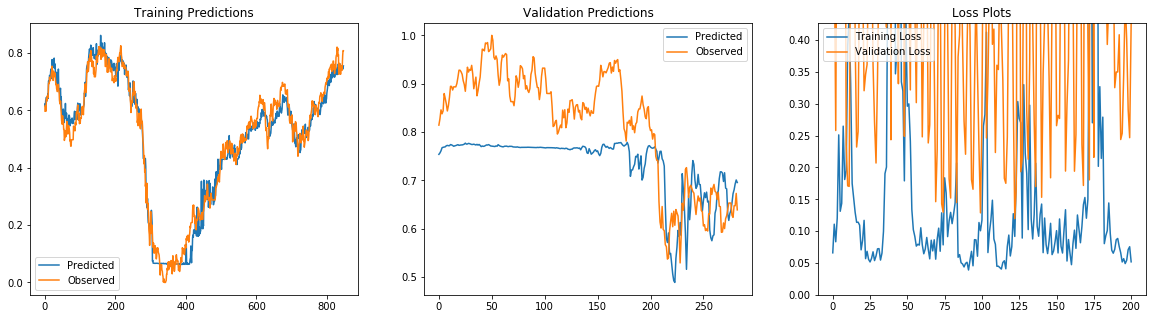

Epoch: 210 Train MSE: 0.06018 Val MSE: 0.40261  Time: 1131.658
Epoch: 220 Train MSE: 0.07015 Val MSE: 0.25889  Time: 1184.946


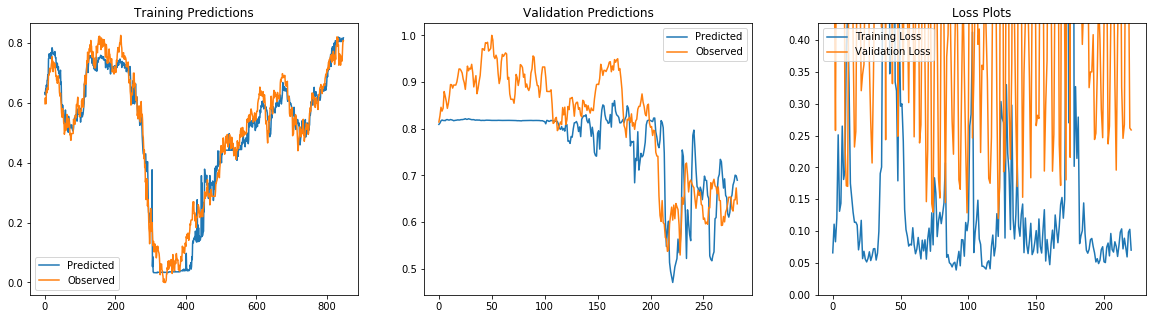

Early Stopping


In [19]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

"""Do I need to declare a data explicitly in the dataset"""
learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=10000,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=10,
                        fig_disp_freq=20, 
                        device=device,
                        patience=100)

# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.training_wrapper()

In [26]:
# learning.create_data_loaders()
print(learning.validate(learning.val_loader))
print(learning.evaluate(learning.best_model, learning.val_loader))

0.11974422965369881
0.11974422965369881


In [0]:
pickle.dump(learning, open("/content/gdrive/My Drive/Chai/Models/Pickles/" + "learning_object", 'wb'))

In [0]:
learning_load = pickle.load(open("/content/gdrive/My Drive/Chai/Models/Pickles/" + "learning_object", 'rb'))

In [0]:
model_save(model, 
           path="/content/gdrive/My Drive/Chai/Models/Pths/",
           name= "partial_dataset_" + "LSTM", 
           val_score=learning.best_val_score)

# mod = model_load(path="Models/Pths",
#            model_name="LSTM_5_854")

Saving model: /content/gdrive/My Drive/Chai/Models/Pths/partial_dataset_LSTM_0_1206.pth


### Plotting

In [0]:
# Scaled Observed
train_true = scaler_data_y.inverse_transform(learning.y_train.numpy().reshape(-1, 1))
val_true  = scaler_data_y.inverse_transform(learning.y_val.numpy().reshape(-1, 1))
test_true  = scaler_data_y.inverse_transform(learning.y_test.numpy().reshape(-1, 1))

# Scaled Predicted
train_pred = scaler_data_y.inverse_transform(np.array(learning.train_predictions).reshape(-1, 1))
val_pred  = scaler_data_y.inverse_transform(np.array(learning.val_predictions).reshape(-1, 1))
test_pred = scaler_data_y.inverse_transform(np.array(learning.test_predictions).reshape(-1, 1))

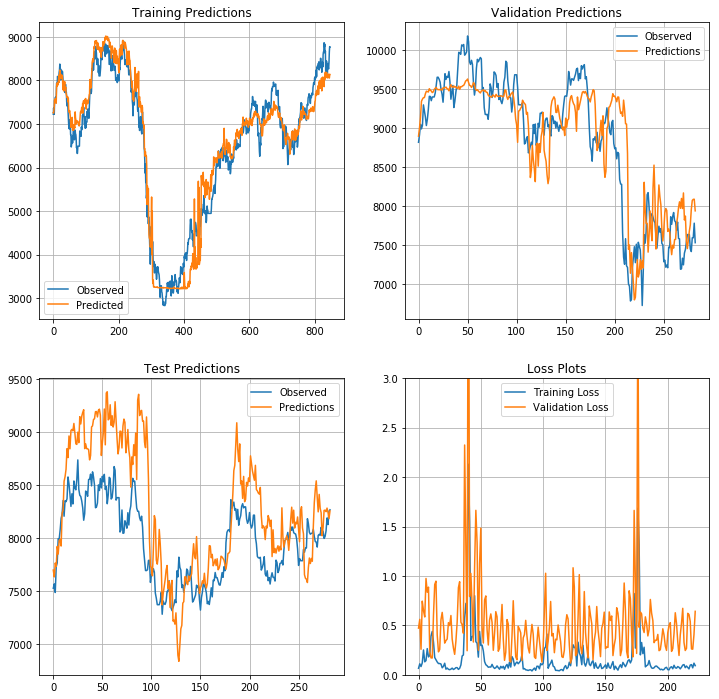

In [96]:
# Rescaling Example
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()
ax[1, 1].set_ylim((0, 3))

epoch_reached = str(len(learning.logs['Training Loss']))
path="/content/gdrive/My Drive/Chai/Models/"
val_loss = learning.best_val_score

plt.savefig(path + str("LSTM_Val_" + str(val_loss)[:5].replace(".", "_") + "_Epoch_" + epoch_reached + ".png"))

plt.show()

In [0]:
# Log Return Observed
lg_train_true = log_returns(pd.Series(train_true[:, 0]), 1)[1:]
lg_val_true  = log_returns(pd.Series(val_true[:, 0]), 1)[1:]
lg_test_true  = log_returns(pd.Series(test_true[:, 0]), 1)[1:]

# Log Return Predicted
lg_train_pred = log_returns(pd.Series(train_pred[:, 0]), 1)[1:]
lg_val_pred  =log_returns(pd.Series(val_pred[:, 0]), 1)[1:]
lg_test_pred = log_returns(pd.Series(test_pred[:, 0]), 1)[1:]

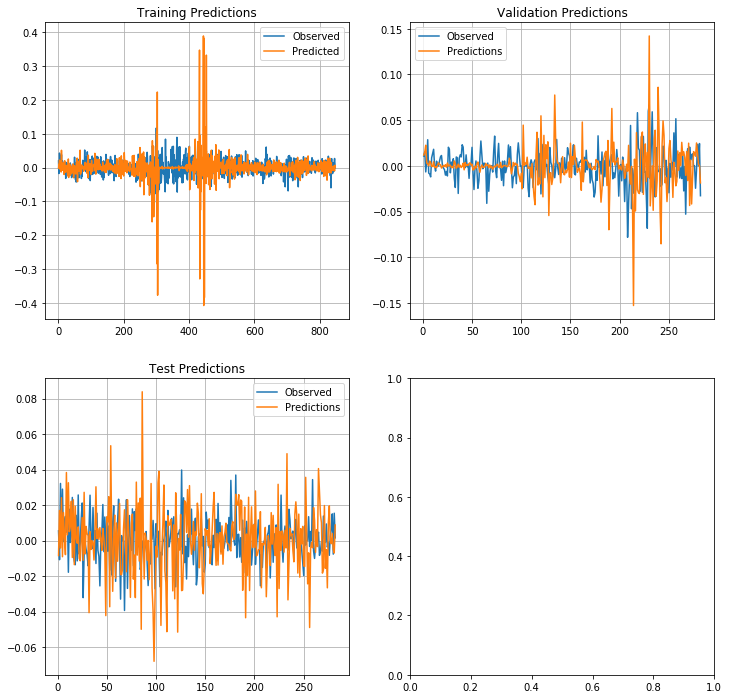

In [98]:
# Rescaling Example
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(lg_train_true, label="Observed")
ax[0, 0].plot(lg_train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(lg_val_true, label="Observed")
ax[0, 1].plot(lg_val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(lg_test_true, label="Observed")
ax[1, 0].plot(lg_test_pred, label="Predictions")
ax[1, 0].legend()

# Results

In [99]:
# mse, mae, mde = evaluate(learning.test_predictions, learning.y_test.numpy())
# print(mse, mae, mde)

mse, mae, mde = evaluate(lg_test_pred, lg_test_true)
print(mse, mae, mde)

0.0005335094 0.018184919 0.4858156028368794


In [0]:
# The minimum validation loss
best_model_epoch = learning.logs['Validation Loss'].index(val_loss)
train_loss = learning.logs['Training Loss'][best_model_epoch]
test_loss = learning.evaluate(learning.best_model, learning.test_loader)

In [49]:
num_epoch = 250
train_time = learning.logs["Time"]
full_save(learning.best_model, 
          "Full_Run",
          optimiser,
          num_epoch, 
          learning_rate, 
          momentum,
          weight_decay, 
          use_lg_returns,
          PCA_used, 
          data_X,
          train_loss,
          val_loss, 
          test_loss,
          train_time, 
          hidden_dim,
          mse,
          mae,
          mde,
          path="/content/gdrive/My Drive/Chai/Models/") 

NameError: ignored

## Persistance

In [0]:
plt.title("Persistance vs Observed Values")
plt.plot(learning.train_predictions, label="Predicted")
plt.plot(shift(learning.train_predictions, 5), label="Observed")
plt.legend()

In [0]:
df = df_full[["target"]]
# Taking t-1 to be the value for t
df["persistance"] = df.shift(1)
df.dropna(inplace=True)
# Calculating metrics for these columns
MSE, MAE, MDE = evaluate(df, "target", "persistance")

In [0]:
print(df[:5])
print(df[-5:])

In [0]:
# Placing in results dataframe
results = pd.DataFrame(columns={"MSE", "MAE", "MDE"})
results.index.name = 'Name'
results.head()
results.loc["persistance"] = [MSE, MAE, MDE] 
results.head()